In [ ]:
import lightgbm as lgb
import pandas as pd
import numpy as np
from scipy.io import arff
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt


Fitting 10 folds for each of 20 candidates, totalling 200 fits
[LightGBM] [Info] Number of positive: 12837, number of negative: 5390
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008154 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 18227, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.704285 -> initscore=0.867786
[LightGBM] [Info] Start training from score 0.867786
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

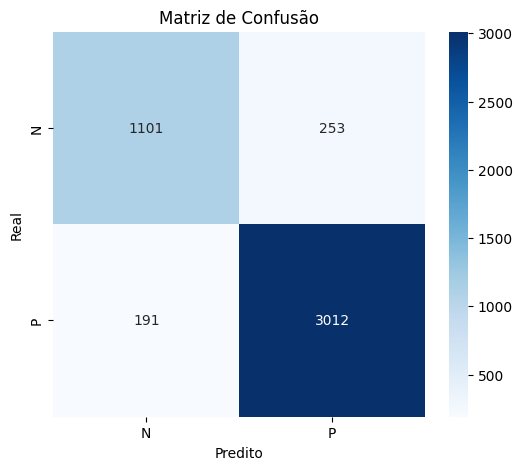


Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.85      0.81      0.83      1354
           1       0.92      0.94      0.93      3203

    accuracy                           0.90      4557
   macro avg       0.89      0.88      0.88      4557
weighted avg       0.90      0.90      0.90      4557


Melhores Hiperparâmetros:
{'subsample': 1.0, 'reg_lambda': 10, 'num_leaves': 127, 'n_estimators': np.int64(350), 'max_depth': np.int64(7), 'learning_rate': 0.05, 'colsample_bytree': 0.8}


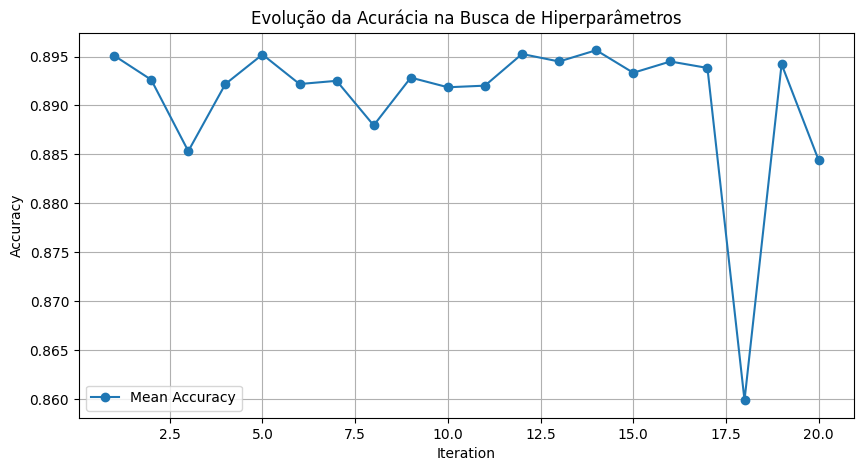

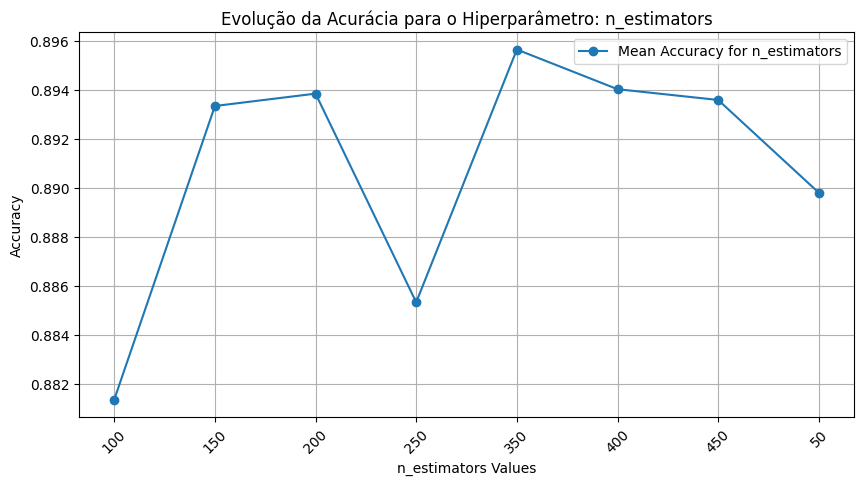

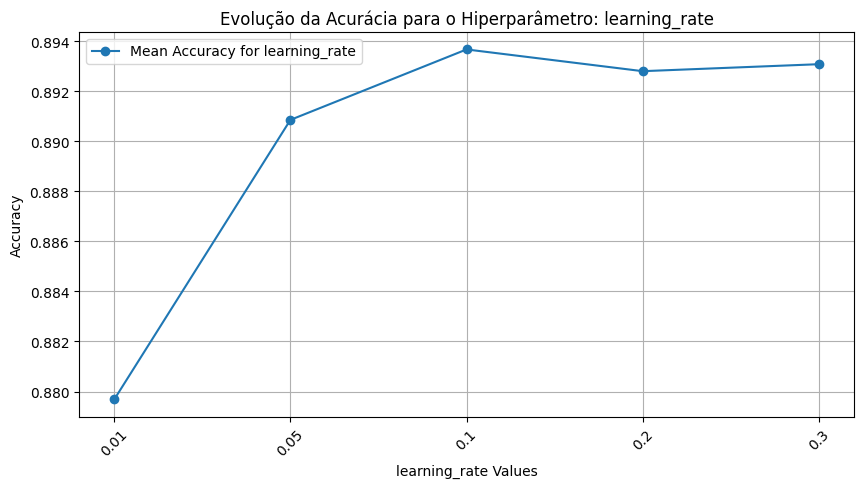

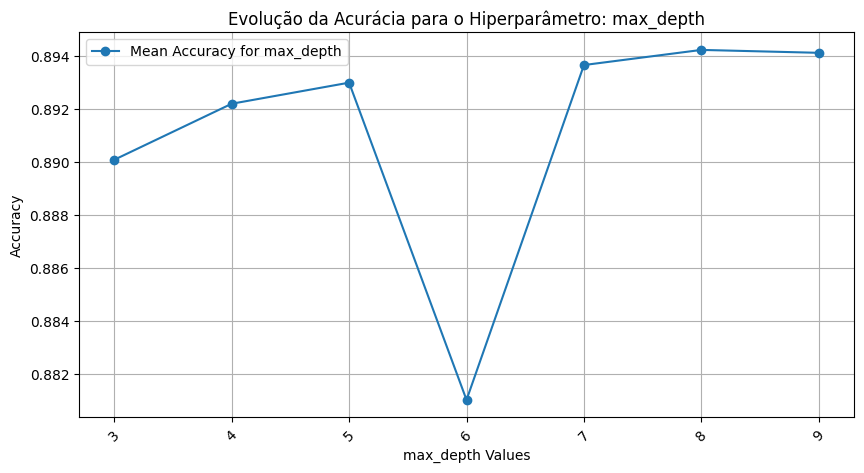

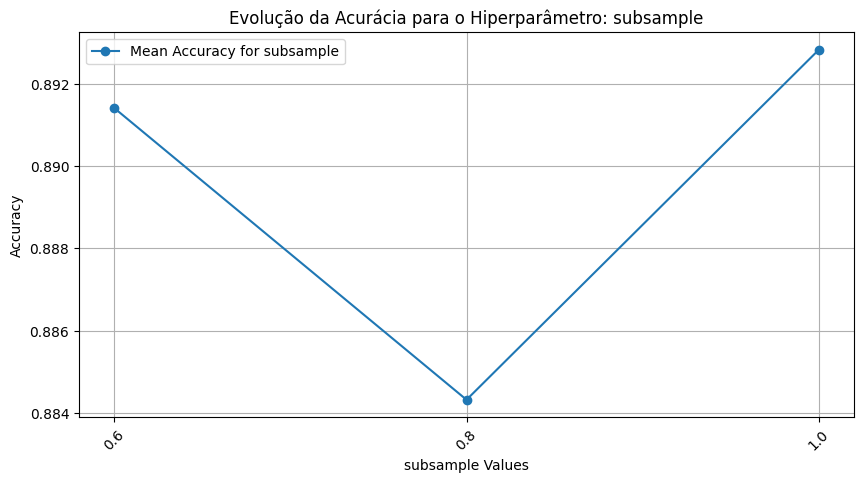

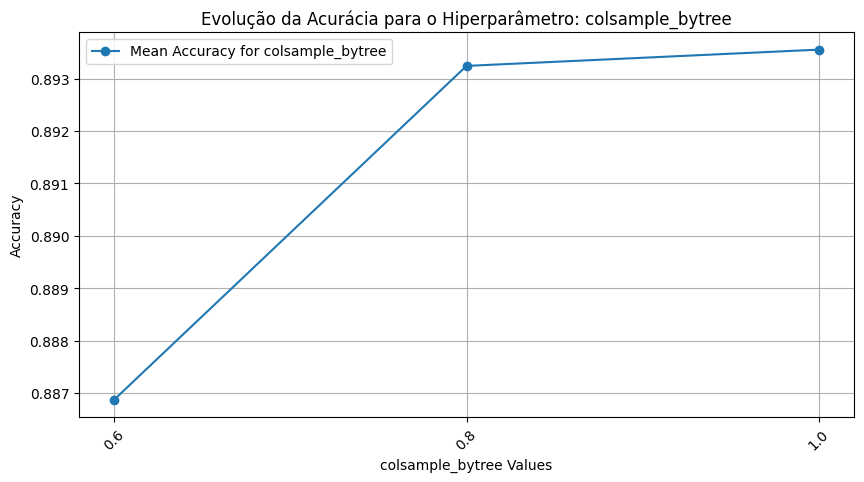

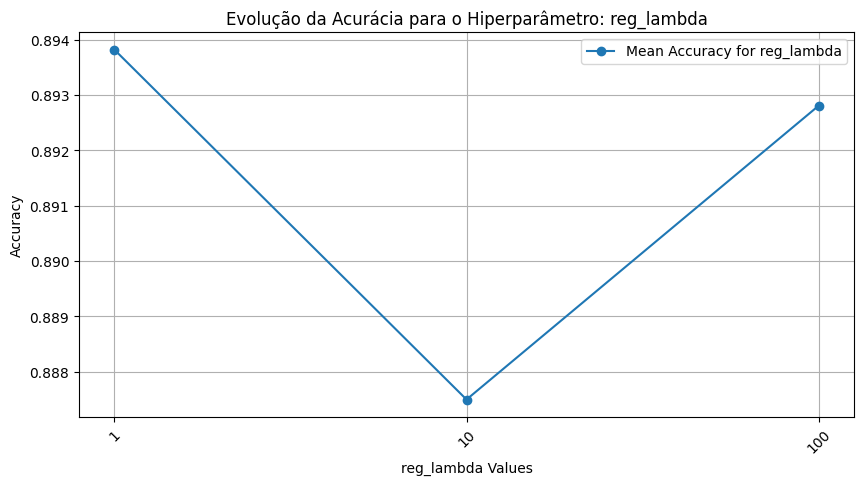

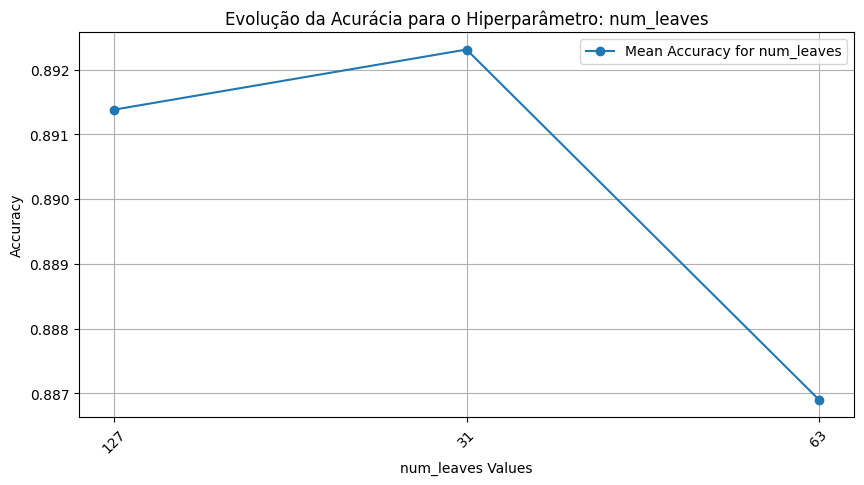

In [ ]:
arff_file = arff.loadarff('house_16H.arff')
df = pd.DataFrame(arff_file[0])

train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

X_train = train_df.drop(columns=['binaryClass'])
y_train = train_df['binaryClass'].map({'N': 0, 'P': 1})
X_test = test_df.drop(columns=['binaryClass'])
y_test = test_df['binaryClass'].map({'N': 0, 'P': 1})

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

param_grid = {
    'n_estimators': np.arange(50, 500, 50),
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'max_depth': np.arange(3, 10),
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_lambda': [1, 10, 100],
    'num_leaves': [31, 63, 127]
}

lgb_clf = lgb.LGBMClassifier(objective='binary', metric='binary_error')

search = RandomizedSearchCV(
    lgb_clf, param_distributions=param_grid, n_iter=20, cv=cv,
    scoring='accuracy', n_jobs=-1, random_state=42, verbose=1
)
search.fit(X_train, y_train)

best_lgb = search.best_estimator_

y_pred = best_lgb.predict(X_test)
y_prob = best_lgb.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

print("\nDesempenho no conjunto de teste:")
print(f"Acurácia: {accuracy:.4f}")
print(f"Precisão: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"AUC-ROC: {roc_auc:.4f}")

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['N', 'P'], yticklabels=['N', 'P'])
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confusão")
plt.show()

print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred))

best_params = search.best_params_

print("\nMelhores Hiperparâmetros:")
print(best_params)

plt.figure(figsize=(10, 5))
plt.plot(range(1, 21), search.cv_results_['mean_test_score'], marker='o', linestyle='-', label='Mean Accuracy')
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.title("Evolução da Acurácia na Busca de Hiperparâmetros")
plt.legend()
plt.grid()
plt.show()

def plot_hyperparameter_evolution(results, param_name):
    param_values = [str(param) for param in results['param_' + param_name]]
    mean_scores = results['mean_test_score']
    std_scores = results['std_test_score']

    df = pd.DataFrame({
        'param_value': param_values,
        'mean_score': mean_scores,
        'std_score': std_scores
    })

    df_grouped = df.groupby('param_value').agg({'mean_score': 'mean', 'std_score': 'mean'}).reset_index()

    plt.figure(figsize=(10, 5))
    plt.plot(df_grouped['param_value'], df_grouped['mean_score'], marker='o', linestyle='-', label=f'Mean Accuracy for {param_name}')
    plt.xlabel(f"{param_name} Values")
    plt.ylabel("Accuracy")
    plt.title(f"Evolução da Acurácia para o Hiperparâmetro: {param_name}")
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.show()

for param_name in param_grid.keys():
    plot_hyperparameter_evolution(search.cv_results_, param_name)


<ipython-input-7-42d440ba92d4>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=metrics, palette='viridis')


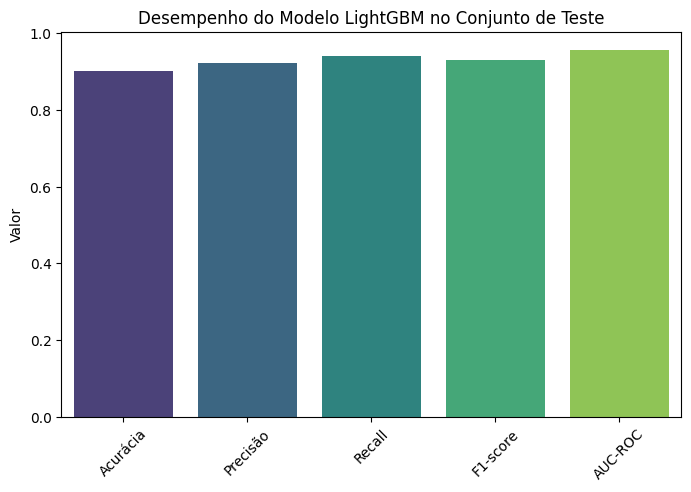

F1-score no Treino: 0.9703
F1-score no Teste: 0.9314
O modelo apresenta um equilíbrio entre treino e teste.


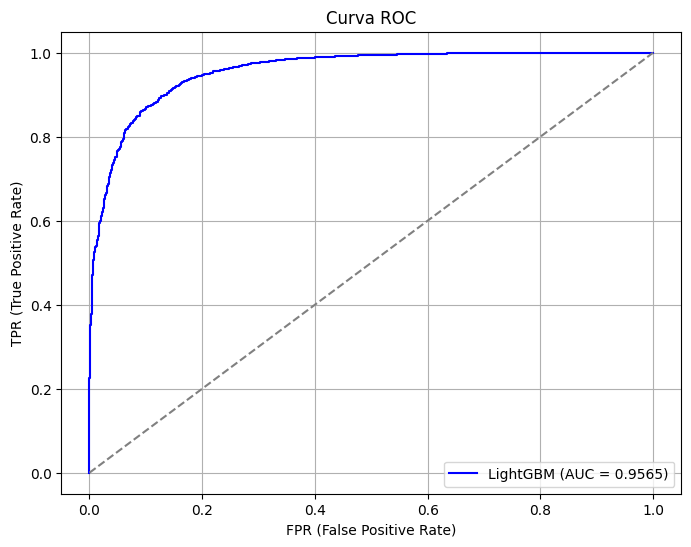


Conclusões:
O modelo LightGBM foi avaliado usando diversas métricas. Os resultados indicam que o modelo conseguiu generalizar bem, utilizando um conjunto de hiperparâmetros ajustados.


In [ ]:
# Comparação de Desempenho
metrics = [accuracy, precision, recall, f1, roc_auc]
labels = ["Acurácia", "Precisão", "Recall", "F1-score", "AUC-ROC"]
plt.figure(figsize=(8, 5))
sns.barplot(x=labels, y=metrics, palette='viridis')
plt.title("Desempenho do Modelo LightGBM no Conjunto de Teste")
plt.ylabel("Valor")
plt.xticks(rotation=45)
plt.show()

# Overfitting vs. Underfitting
train_pred = best_lgb.predict(X_train)
train_f1 = f1_score(y_train, train_pred)
print(f"F1-score no Treino: {train_f1:.4f}")
print(f"F1-score no Teste: {f1:.4f}")

if train_f1 - f1 > 0.1:
    print("O modelo pode estar sofrendo de overfitting.")
elif f1 - train_f1 > 0.1:
    print("O modelo pode estar sofrendo de underfitting.")
else:
    print("O modelo apresenta um equilíbrio entre treino e teste.")

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'LightGBM (AUC = {roc_auc:.4f})', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("FPR (False Positive Rate)")
plt.ylabel("TPR (True Positive Rate)")
plt.title("Curva ROC")
plt.legend()
plt.grid()
plt.show()

# Conclusões
print("\nConclusões:")
print("O modelo LightGBM foi avaliado usando diversas métricas. Os resultados indicam que o modelo conseguiu generalizar bem, utilizando um conjunto de hiperparâmetros ajustados.")
